In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import beam_propagation_method as bpm

# Initialize needed parameters (were already provided)

In [13]:
# computational parameters                                                         
z_end   = 200       # propagation distance                                         
lam = 1         # wavelength                                                   
nd = 1.455     # reference index                                              
xa = 50        # size of computational window                                 
Nx = 251       # number of transverse points                                  
dx = xa/(Nx-1) # transverse step size                                         
                                                                                   
# waveguide parameters                                                             
xb = 2.0       # size of waveguide                                            
n_cladding = 1.45      # cladding index                                           
n_core = 1.46     # core refr. index                                             
                                                                                   
# source width                                                                     
w = 2.0       # Gaussian beam width                                          
                                                                                   
# propagation step size                                                            
dz = 0.5                                                                           
output_step = round(1.0/dz)                                                     
                                                                                   
# create index distribution                                                        
n, x = bpm.waveguide(xa, xb, Nx, n_cladding, n_core)                                   
                                                                                   
# create initial field                                                             
v_in, x = bpm.gauss(xa, Nx, w)                                                         

v_in = v_in/np.sqrt(np.sum(np.abs(v_in)**2)) # normalize power to unity 

v_out, z = bpm.beamprop_CN(v_in, lam, dx, n, nd, z_end, dz, 1)

extent = (0, z_end, x[0], x[-1])

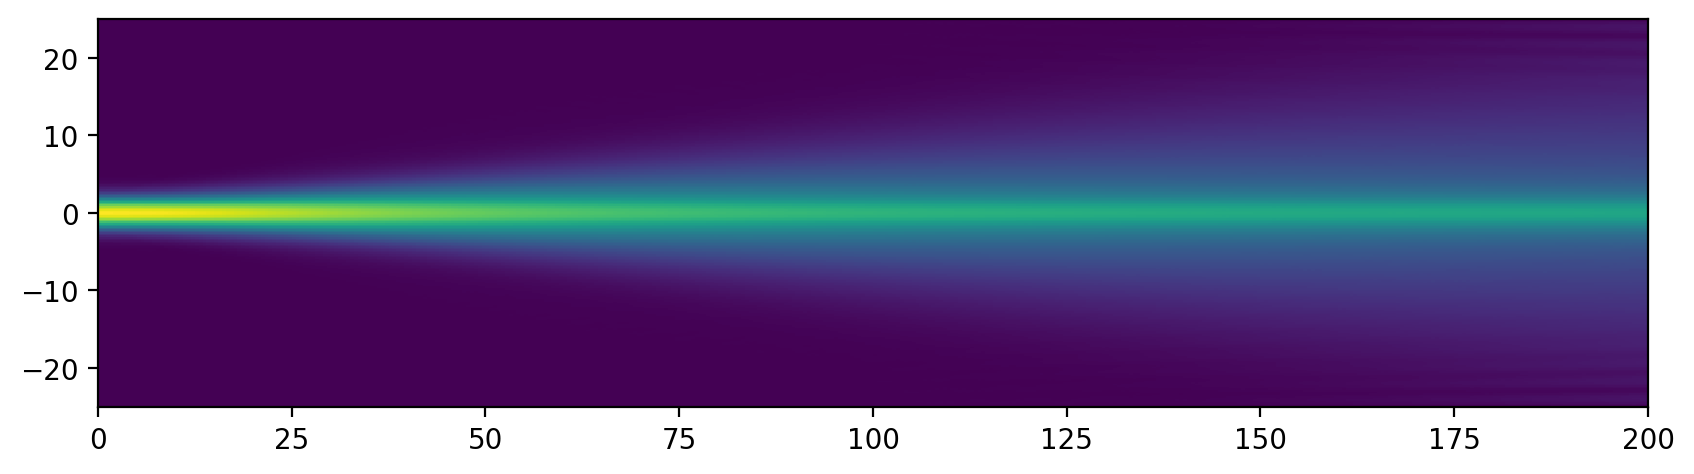

In [14]:
plt.figure(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(np.transpose(np.abs(v_out)), extent=extent)

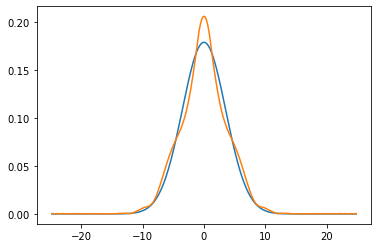

In [4]:
s = 1
plt.plot(x[s:-s], np.abs(v_out[0, s:-s]))
plt.plot(x[s:-s], np.abs(v_out[100, s:-s]))
#plt.plot(x[s:-s], np.abs(n[s:-s]))
#plt.plot(x[s:-s], v_in[s:-s])

In [5]:
v_out.shape

(400, 251)

In [6]:
j = 100
print((np.abs(v_out[0, :]) - np.abs(v_out[j, :]))/(np.abs(v_out[0, :]) + np.abs(v_out[j, :])))
print(np.abs(v_out[0, :]))
print(np.abs(v_out[j, :]))

[-1.         -1.         -1.         -0.9999998  -0.9999998  -0.9999998
 -0.9999998  -0.9999995  -0.9999984  -0.9999994  -0.9999993  -0.99999857
 -0.99999255 -0.99999607 -0.9999972  -0.99999535 -0.99998254 -0.99997264
 -0.9999849  -0.9999829  -0.9999678  -0.99895006 -0.99994224 -0.9999342
 -0.9998581  -0.9995925  -0.9993093  -0.999724   -0.9996315  -0.99919343
 -0.9940338  -0.9986744  -0.99881047 -0.99789834 -0.9929623  -0.9912033
 -0.99519265 -0.9936145  -0.9900693  -0.96269083 -0.97655034 -0.97456664
 -0.9725474  -0.9605393  -0.84676903 -0.8792285  -0.9287391  -0.90684086
 -0.8194692  -0.6658853  -0.6900664  -0.7840701  -0.73163474 -0.63215727
 -0.55956393 -0.7017171  -0.75219744 -0.7122574  -0.5819245  -0.4982215
 -0.5044163  -0.4703296  -0.37206253 -0.17978099  0.1489662   0.29577628
  0.12086101 -0.07378158 -0.22349711 -0.3088351  -0.34312162 -0.34717613
 -0.34145877 -0.33080238 -0.31335965 -0.29406178 -0.26436698 -0.21354067
 -0.15502921 -0.10387186 -0.06601994 -0.04319935 -0.030